## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [119]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [120]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [121]:
rows = df.shape[0]
rows

294478

c. The number of unique users in the dataset.

In [122]:
users = df.user_id.nunique()
users

290584

d. The proportion of users converted.

In [123]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [124]:
errors = df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').index
errors.shape[0]

3893

f. Do any of the rows have missing values?

In [125]:
sum(df.isnull().any(axis=1))

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [126]:
df2 = df.drop(errors)

In [127]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [128]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [129]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [130]:
df2[df.user_id == 773192]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [131]:
df2 = df2.drop(df2.user_id.duplicated())

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [132]:
df2.converted.mean()

0.11959749882133504

b. Given that an individual was in the `control` group, what is the probability they converted?

In [133]:
p_new_real = df2[df2["group"] == "control"].converted.mean()
p_new_real

0.12038796189217468

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [134]:
p_old_real = df2[df2["group"] == "treatment"].converted.mean()
p_old_real

0.11880724790277405

d. What is the probability that an individual received the new page?

In [135]:
(df2[df2["landing_page"] == "new_page"].shape[0])/(df2.shape[0])

0.5000671064721611

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**
>
>No I do not think this is enough evidence to make any conclusions because the probabilities are very close and this analysis doesn't account for confidence levels of accuracy.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
>
>**Null:** The new page is equally as good or worse as the old page (ie. it converts as many or fewer users as the old page).
>
>**Alternative:** The new page is better than the old page (ie. it converts more users than the old page).

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [136]:
p_new = df2.converted.mean()
p_new

0.11959749882133504

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [137]:
p_old = df2.converted.mean()
p_old

0.11959749882133504

c. What is $n_{new}$, the number of individuals in the treatment group?

In [138]:
n_new = df2[df2.group == "treatment"].shape[0]
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [139]:
n_old = df2[df2.group == "control"].shape[0]
n_old

145272

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [140]:
new_page_converted = np.random.choice([0, 1], n_new, replace = True, p = [1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [141]:
old_page_converted = np.random.choice([0, 1], n_old, replace = True, p = [1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [142]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.001050426224089962

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [143]:
p_diffs = []
new_vals = np.random.binomial(n_new, p_new, 10000)/n_new
old_vals = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_vals - old_vals
p_diffs

array([ 0.00016017, -0.00117469, -0.00026645, ..., -0.00044498,
        0.00048378,  0.00195007])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

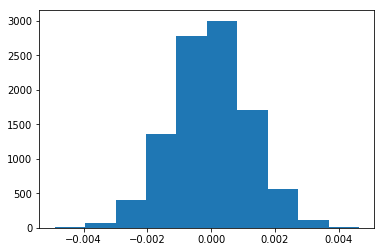

In [144]:
p_diffs = np.asarray(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [145]:
p_diff_real = p_new_real - p_old_real
(p_diffs > p_diff_real).mean()

0.089499999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
>
>This is the p-value. The p-value is how likely the statistical results are accurate when the null value is true. In order to reject the null, you want a 95% or higher confidence level. A p-value should be under 0.05 in order to achieve this confidence level.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [146]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"').shape[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').shape[0]
n_old = df2[df2.landing_page == "old_page"].shape[0]
n_new = df2[df2.landing_page == "new_page"].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [147]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
z_score, p_value

(1.3129757845137815, 0.09459555403864528)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
>
>The z-score is between -1.96 and 1.96, and the p-value is greater than 0.05, which. This does not give us a high enough confidence level to reject the null. This agrees with our previous findings and is similiar to the p-value I found from the simulation.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
>
> Logistic Regression, since this is the model that works best for dependent categorical variables.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [148]:
df2['intercept'] = 1

dummies = pd.get_dummies(df2['group'])
dummies.columns = ["drop", "ab_page"]
df2 = df2.join(dummies.ab_page)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [149]:
lm = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [150]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.724
Date:                Tue, 19 Feb 2019   Prob (F-statistic):              0.189
Time:                        05:29:20   Log-Likelihood:                -85267.
No. Observations:              290583   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.313      0.189      -0.004       0.001
==============================================================================
Omnibus:                   125552.570   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414308.144
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**
>
>The p-value is 0.189. This is about double the p-value I found from the simulation and the z-test. This is because the simulation and z-test were one tailed tests, this means they only test the statistic in one direction and doesn't account for both cases of being larger or smaller than the mean. A one tailed test can give more information about the relationship in a certain direction and can be useful when we are primarialy concerned with that one-way relationship.
>
>For this case we are concerned about the relationship in both directions since the new landing page can do worse or better than the old page. Given this scenario this two-tailed p-value is more valuable for us.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
>
>It is a good idea to use other factors in a model because they could show if other factors are a better predictor of success.
>
>Adding multiple factors could also be misleading especially in cases of multicollinearity, that is when 2 or more of the predictor variables are correlated to each other.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [151]:
countries = pd.read_csv("countries.csv")
dummies2 = pd.get_dummies(countries['country'])
countries = countries.join(dummies2)
df3 = df2.set_index('user_id').join(countries.set_index('user_id'))
df3.head()

lm2 = sm.OLS(df3['converted'], df3[['intercept', 'CA', 'US']])
results2 = lm2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Tue, 19 Feb 2019   Prob (F-statistic):              0.201
Time:                        05:29:21   Log-Likelihood:                -85267.
No. Observations:              290583   AIC:                         1.705e+05
Df Residuals:                  290580   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1206      0.001    100.044      0.000       0.118       0.123
CA            -0.0053      0.003     -1.787      0.074      -0.011       0.001
US            -0.0010      0.001     -0.746      0.456      -0.004       0.002
==============================================================================
Omnibus:                   125551.502   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414300.851
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         6.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>
>No, it doesn't appear that country had an impact on conversion rate given that there are no significant p-values.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [152]:
df3['uk_treatment'] = 0
df3.loc[df3.eval('UK == 1 and ab_page == 1'), 'uk_treatment'] = 1
df3['uk_control'] = 0
df3.loc[df3.eval('UK == 1 and ab_page == 0'), 'uk_control'] = 1

df3['us_treatment'] = 0
df3.loc[df3.eval('US == 1 and ab_page == 1'), 'us_treatment'] = 1
df3['us_control'] = 0
df3.loc[df3.eval('US == 1 and ab_page == 0'), 'us_control'] = 1

df3['ca_treatment'] = 0
df3.loc[df3.eval('CA == 1 and ab_page == 1'), 'ca_treatment'] = 1
df3['ca_control'] = 0
df3.loc[df3.eval('CA == 1 and ab_page == 0'), 'ca_control'] = 1

lm3 = sm.OLS(df3['converted'], df3[['intercept', 'uk_treatment', 'uk_control', 'us_treatment', 'us_control', 'ca_treatment']])
results3 = lm3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.468
Date:                Tue, 19 Feb 2019   Prob (F-statistic):              0.197
Time:                        05:29:21   Log-Likelihood:                -85265.
No. Observations:              290583   AIC:                         1.705e+05
Df Residuals:                  290577   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.1188      0.004     31.057      0.000       0.111       0.126
uk_treatment     0.0024      0.004      0.570      0.569      -0.006       0.011
uk_control       0.0012      0.004      0.296      0.767      -0.007       0.009
us_treatment    -0.0003      0.004     -0.080      0.936      -0.008       0.007
us_control       0.0018      0.004      0.467      0.640      -0.006       0.010
ca_treatment    -0.0069      0.005     -1.277      0.202      -0.017       0.004
==============================================================================
Omnibus:                   125548.549   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414280.725
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>
>I tried a different approach and seperated the combinations of country and ab_page into 6 different variables. Although still, none of the p-values are less than 0.05 so I believe there is no significant effect here.

In [153]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0